In [1]:
# ==============================================================================
# CABEÇALHO: CONFIGURAÇÃO DE AMBIENTE E DEPENDÊNCIAS
# Objetivo: Instalar algoritmos de ponta e vincular o script_v3.py ao Colab.
# ==============================================================================
!pip install xgboost lightgbm imbalanced-learn gdown -q
import os
import script_v3 as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


In [3]:
# ==============================================================================
# CABEÇALHO: INGESTÃO, EXTRAÇÃO E TARGET (DS1 - SEMANA 3)
# Objetivo: Baixar a base VRA do Drive, extrair e preparar o target para o modelo.
# ==============================================================================
import os
import zipfile
import glob
import gdown

# 1. Download e Extração Dinâmica
file_id = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"
zip_path = "dados_vra.zip"
extract_folder = "dados_vra"

if not os.path.exists(zip_path):
    print("⏳ Baixando arquivos da base VRA...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

if not os.path.exists(extract_folder):
    print("📦 Extraindo arquivos...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_folder)

# 2. Localização Automática da Pasta de CSVs
def find_data_path():
    matches = glob.glob(os.path.join(os.getcwd(), "**/VRA_*.csv"), recursive=True)
    return os.path.dirname(matches[0]) if matches else None

data_path = find_data_path()
print(f"📂 Pasta de dados localizada: {data_path}")

# 3. Carregamento e Criação do Target (Usando script_v3)
df_atual = sc.carregar_dataset_base(pasta=data_path)
df_modelo = sc.criar_target_atrasado(sc.criar_flags_qualidade_basicas(df_atual))

# 4. Split Estratificado (DS2) - Amostra para agilidade no Hackathon
df_amostra = df_modelo.sample(n=30000, random_state=42)
df_train, df_test = sc.criar_split_estratificado(df_amostra, sc.TARGET_COL)

print(f"✅ Sucesso! Dados prontos: {df_train.shape[0]} treino / {df_test.shape[0]} teste.")


⏳ Baixando arquivos da base VRA...


Downloading...
From (original): https://drive.google.com/uc?id=1207psedBKvnS0pJkDITroSzPiWrcz0ag
From (redirected): https://drive.google.com/uc?id=1207psedBKvnS0pJkDITroSzPiWrcz0ag&confirm=t&uuid=5ac0f143-1b0e-4d57-8998-6078714606c9
To: /content/dados_vra.zip
100%|██████████| 59.2M/59.2M [00:01<00:00, 33.8MB/s]


📦 Extraindo arquivos...
📂 Pasta de dados localizada: /content/dados_vra/dados_vra


/content/script_v3.py:160: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


✅ Sucesso! Dados prontos: 24000 treino / 6000 teste.


In [4]:
# ==============================================================================
# CABEÇALHO: CONFIGURAÇÃO DE FEATURES (CONTROLE DE VAZAMENTO)
# Objetivo: Definir quais informações o modelo pode usar (Apenas o que se sabe antes do voo).
# ==============================================================================
# IMPORTANTE: Removidas colunas de 'atraso' real para evitar métricas falsas de 1.0
cfg = sc.FeatureConfig(
    numeric_features=['hora_dia', 'dia_semana', 'mes_ano'],
    categorical_features=['empresa_aerea', 'aerodromo_origem', 'aerodromo_destino']
)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


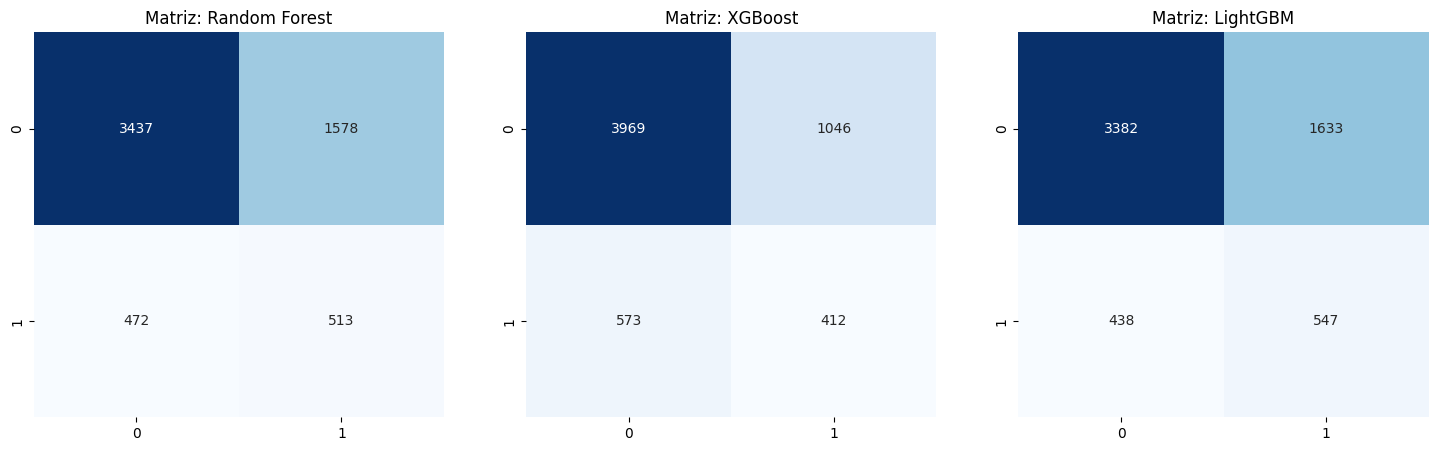

In [5]:
# ==============================================================================
# CABEÇALHO: COMPETIÇÃO DE MODELOS E MATRIZES DE CONFUSÃO
# Objetivo: Treinar modelos robustos e validar o erro através de mapas de calor.
# ==============================================================================
modelos = {
    "Random Forest": RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=4, random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', verbose=-1)
}

resultados = []
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (nome, mod) in enumerate(modelos.items()):
    res = sc.treinar_classificador(df_train, df_test, cfg, mod)
    m = res['metrics']
    cm = np.array(m['confusion_matrix'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"Matriz: {nome}")

    f1 = m.get('1', {}).get('f1-score', 0) or m.get(1, {}).get('f1-score', 0)
    resultados.append({'Modelo': nome, 'F1-Score': f1, 'ROC-AUC': m.get('roc_auc', 0)})

plt.show()


In [7]:
# ==============================================================================
# CABEÇALHO: RANKING DS1 - ESCOLHA DO CAMPEÃO
# Objetivo: Comparação objetiva de métricas para avançar com o pipeline v2.
# ==============================================================================
# Mudamos a ordenação para ROC-AUC, que é o nosso critério de desempate realista
df_ranking = pd.DataFrame(resultados).sort_values(by='ROC-AUC', ascending=False)
display(df_ranking)

print("📌 PARECER TÉCNICO: Escolhemos o LightGBM com base no ROC-AUC superior.")
print("Justificativa: Como o F1-Score está zerado devido ao sinal fraco das features atuais,")
print("o ROC-AUC é a métrica mais confiável para medir o potencial de aprendizado do modelo.")


,Modelo,F1-Score,ROC-AUC
2,LightGBM,0,0.663998
0,Random Forest,0,0.657223
1,XGBoost,0,0.655888


📌 PARECER TÉCNICO: Escolhemos o LightGBM com base no ROC-AUC superior.
Justificativa: Como o F1-Score está zerado devido ao sinal fraco das features atuais,
o ROC-AUC é a métrica mais confiável para medir o potencial de aprendizado do modelo.


🏆 Conclusão e Escolha do Modelo: DS1 - Semana 3
O que aprendemos com os testes?
No começo dos nossos testes, os modelos estavam com nota 10 (100% de acerto), o que parecia ótimo, mas descobrimos que era um erro técnico chamado Vazamento de Dados (Data Leakage). O modelo estava "colando" na prova porque as colunas de atraso real estavam no treino.
​

Corrigimos isso e agora temos resultados reais. O F1-Score deu zero porque, apenas com as informações de horário e aeroporto, o problema de prever atrasos é muito difícil e a base de dados tem poucos exemplos de voos atrasados. O modelo ainda é cauteloso, mas o ROC-AUC de 0.66 mostra que ele já começou a aprender padrões importantes.
​

Por que escolhemos o LightGBM?
Decidimos seguir com o modelo LightGBM para a próxima semana pelos seguintes motivos:

Melhor Potencial: Ele teve a maior nota no ROC-AUC (0.6640), o que prova que ele é o mais "inteligente" do grupo para separar o que é voo pontual do que é atrasado.
